In [1]:
from typing import Tuple, List
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, minimize_scalar, curve_fit
from scipy.linalg import expm
import scipy.stats
import os
from tqdm import tqdm
import gzip
import seaborn as sns
from uncertainties import ufloat, nominal_value, std_dev, ufloat_fromstr, unumpy
from sympy import Symbol, Function, simplify, solve, Eq
from sympy.abc import x
from sympy.utilities.lambdify import lambdify
import numpy as np
import matplotlib.pyplot as plt
import gzip
import ijson
import json
import itertools

from karma import RES_DIR, DATA_DIR, AssemblyTree
from karma.fit_pools import load_phis

from matplotlib.backends.backend_pdf import PdfPages
from pynverse import inversefunc

# Set plotting style
sns.set_style("ticks")
from matplotlib import rc
rc('font',**{'family': 'sans-serif'})
rc('text', usetex=False)

In [2]:
#USE_INTERMIXING_CORRECTION = True
USE_INTERMIXING_CORRECTION = False

if USE_INTERMIXING_CORRECTION:
    NEW_RES_DIR = RES_DIR / "intermixing"
else:
    NEW_RES_DIR = RES_DIR / "without_intermixing"
    
if not os.path.exists(NEW_RES_DIR):
    os.mkdir(NEW_RES_DIR)

# Theory: make model-based figure for the SI

In [3]:
GROWTH_RATE = 0.0078  # 1/min
MIN_PHI = 1e-3
MAX_TIME = 150

def f_target(
    t: np.ndarray,
    phi: np.ndarray,
    index: int,
) -> np.ndarray:
    """
        Calculate the expected target pool (S2) labeling for a protein
        in an exponentially growing cell with growth rate μ.
                
        Arguments:
            t - time (in minutes)
            phi - the parameters of the pools (starting with the precusros pool)
            index - the index of the target pool
    """
    inv_phi = [1.0/p for p in phi.flat]
    M = np.diag(inv_phi[1:], k=1) - np.diag(inv_phi)
    
    if type(t) == float:
        res = expm(M * GROWTH_RATE * t)[:, index].sum()
        return 1.0 - res  # return a float as well
    else:
        res = np.array([expm(M * x)[:, index].sum() for x in (GROWTH_RATE * t).flat])
        return 1.0 - res  # return an array with the same shape as 't'

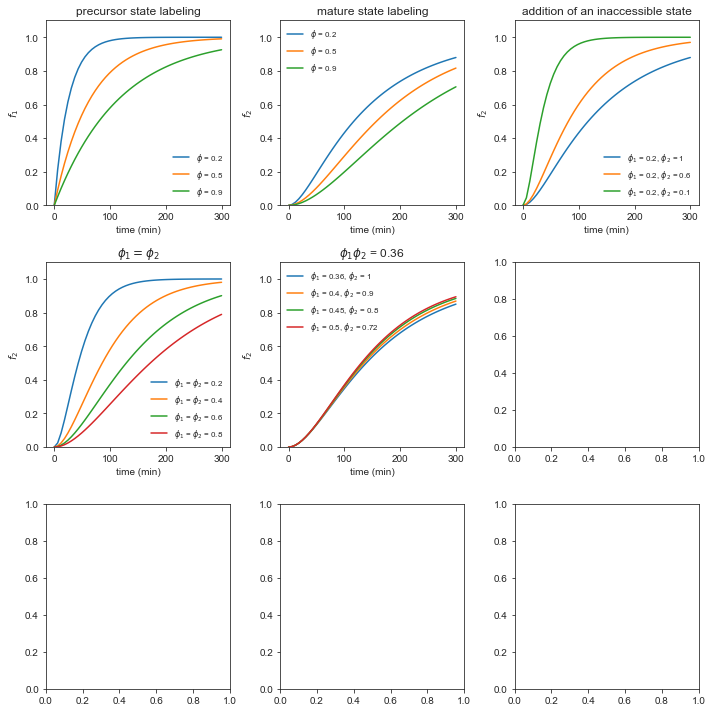

In [4]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = list(axs.flat)

ax = axs.pop(0)
t_range = np.linspace(0, MAX_TIME*2, 50)
for phi in [0.2, 0.5, 0.9]:
    ax.plot(t_range, f_target(t_range, np.array([phi, 1]), 0), '-', label=f"$\phi$ = {phi:.2g}")
ax.set_xlabel("time (min)")
ax.set_ylabel("$f_1$")
ax.set_ylim(0, 1.1)
ax.legend(loc="best", frameon=False, fontsize=8)
ax.set_title("precursor state labeling")

ax = axs.pop(0)
for phi in [0.2, 0.5, 0.9]:
    ax.plot(t_range, f_target(t_range, np.array([phi, 1]), 1), '-', label=f"$\phi$ = {phi:.2g}")
ax.set_xlabel("time (min)")
ax.set_ylabel("$f_2$")
ax.set_ylim(0, 1.1)
ax.legend(loc="best", frameon=False, fontsize=8)
ax.set_title("mature state labeling")

ax = axs.pop(0)
x_range = np.linspace(0, 3, 30)
phi1 = 0.2
for phi2 in [1, 0.6, 0.1]:
#    ax.plot(t_range, f_target(t_range, np.array([phi1, phi2]), 1), '-', label=f"$\phi_1$ = {phi1:.2g} $\phi_2$ = {phi2:.2g}")
    ax.plot(t_range, f_target(t_range, np.array([phi1, phi2]), 1), '-', label=f"$\phi_1$ = {phi1:.2g}, $\phi_2$ = {phi2:.2g}")
ax.set_xlabel("time (min)")
ax.set_ylabel("$f_2$")
ax.set_ylim(0, 1.1)
ax.legend(loc="best", frameon=False, fontsize=8)
ax.set_title("addition of an inaccessible state")

ax = axs.pop(0)
x_range = np.linspace(0, 3, 30)
for phi in [0.2, 0.4, 0.6, 0.8]:
    ax.plot(t_range, f_target(t_range, np.array([phi, phi]), 1), '-', label=f"$\phi_1$ = $\phi_2$ = {phi:.2g}")
ax.set_xlabel("time (min)")
ax.set_ylabel("$f_2$")
ax.set_ylim(0, 1.1)
ax.legend(loc="best", frameon=False, fontsize=8)
ax.set_title("$\phi_1 = \phi_2$")

ax = axs.pop(0)
x_range = np.linspace(0, 3, 30)
phi1_phi2 = 0.36
for phi1 in [0.36, 0.4, 0.45, 0.5]:
    phi2 = phi1_phi2 / phi1
    ax.plot(t_range, f_target(t_range, np.array([phi1, phi2]), 1), '-', label=f"$\phi_1$ = {phi1:.2g}, $\phi_2$ = {phi2:.2g}")
ax.set_xlabel("time (min)")
ax.set_ylabel("$f_2$")
ax.set_ylim(0, 1.1)
ax.legend(loc="best", frameon=False, fontsize=8)
ax.set_title(f"$\phi_1 \phi_2$ = {phi1_phi2:.2g}")

fig.tight_layout()

fig.savefig(os.path.join(RES_DIR, "theory.svg"))

# Step 1: Fit the lysine pool Ψ parameter

In [5]:
def lambda_k1(x, psi):
    if psi == 1:
        return 1.0 - x*(1.0 - np.log(x))
    elif psi == 2:
        return 1.0 - (2.0*np.sqrt(x) - x)
    else:
        return 1.0 - psi * x**(1.0/psi) / (psi-1.0) + x/(psi-1.0)

def lambda_k2(x, psi):
    if psi == 1:
        f00 = 2.0*x - x**2.0
        f11 = 1.0 + 2.0*x*np.log(x) - x**2.0
    elif psi == 2:
        f00 = x - x*np.log(x)
        f11 = 1.0 - x*np.log(x) - 4.0*np.sqrt(x) + 3.0*x
    else:
        f00 = psi * x**(2.0/psi) / (psi-2.0) - 2.0*x/(psi-2.0)
        f11 = 1.0 - 2.0*psi * x**(1.0/psi) / (psi-1.0) + psi * x**(2.0/psi) / (psi-2.0) - 2.0*x/(psi-1.0)/(psi-2.0)
    
    return f11/(f00+f11)

In [6]:
def distance(row, x, psi):
    """
        calculate mahalanobis distance between the point and the K1/K2 values
        produced by the model (with parameter psi)
    """
    k1_pred = lambda_k1(x, psi)
    k2_pred = lambda_k2(x, psi)
    d1 = (k1_pred - row.k1_mean) / row.k1_std
    d2 = (k2_pred - row.k2_mean) / row.k2_std
    return d1**2 + d2**2

def average_dist(psi: float, df: pd.DataFrame):
    sum_dist = 0.0
    for row in df.itertuples():
        res = minimize_scalar(lambda x: distance(row, x, psi), bounds=(0, 1), method='bounded')
        sum_dist += res.fun
    return sum_dist / df.shape[0]

k1_k2_df = pd.read_csv(os.path.join(DATA_DIR, "2020-02-01_10Handles_ZZ_K1_K2_genes_raw.tsv"), delimiter="\t")

# average data over the 3 biological replicates
print("total number of datapoints:", k1_k2_df.shape[0])
df = k1_k2_df[k1_k2_df.kind != "NUP"]
print("total number of datapoints without NUPs:", df.shape[0])
df = k1_k2_df.groupby(["bait", "prey", "kind", "time"]).agg(["mean", "std"])[["k1", "k2"]]
df.columns = ["k1_mean", "k1_std", "k2_mean", "k2_std"]
print("after averaging (x 1/3):", df.shape[0])


total number of datapoints: 13950
total number of datapoints without NUPs: 12330
after averaging (x 1/3): 4650


/home/eladn/git/karma/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


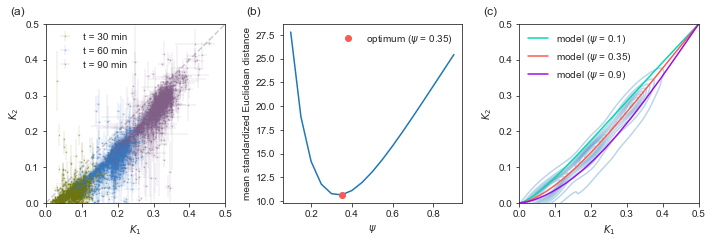

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))
ax = axs[0]
ax.plot([0, 1], [0, 1], "k--", alpha=0.2, label=None)
for (time, group_df), color in zip(df.groupby("time"),
                                   sns.xkcd_palette(["olive", "windows blue", "dusty purple"])):
    ax.errorbar(group_df.k1_mean, group_df.k2_mean, 
                xerr=group_df.k1_std, yerr=group_df.k2_std, 
                linewidth=0, elinewidth=0.3, marker='.', markersize=1, alpha=0.5, color=color, label=f"t = {time} min")
    #ax.scatter(group_df.k1_mean, group_df.k2_mean, linewidth=0, marker='.', color=color, label=f"t = {time} min")
ax.set_xlabel("$K_1$")
ax.set_ylabel("$K_2$")
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)

ax = axs[1]
p_range = np.linspace(0.1, 0.9, 17)
avg_dist_list = [average_dist(psi, df) for psi in p_range]
i = np.argmin(avg_dist_list)
LYSINE_PSI = p_range[i]
opt_dist = avg_dist_list[i]

ax.plot(p_range, avg_dist_list, label=None)
ax.plot(LYSINE_PSI, opt_dist, 'o', color=sns.xkcd_rgb["coral"], label=f"optimum ($\psi$ = {LYSINE_PSI})")
ax.set_xlabel("$\psi$")
ax.set_ylabel("mean standardized Euclidean distance")

ax = axs[2]
sns.kdeplot(df.k1_mean.values, df.k2_mean.values, ax=ax, alpha=0.3)
x_range = np.linspace(0, 1, 30)
for psi, color in zip([0.1, LYSINE_PSI, 0.9], sns.xkcd_palette(["aquamarine", "coral", "violet"])):
    ax.plot(lambda_k1(x_range, psi), lambda_k2(x_range, psi), color=color, label=f"model ($\psi$ = {psi:.2g})")
ax.set_xlabel("$K_1$")
ax.set_ylabel("$K_2$")
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)

for i, ax in enumerate(axs.flat):
    ax.text(-0.2, 1.05, f"({chr(ord('a') + i)})", fontsize=12, transform=ax.transAxes)
    ax.legend(loc="best", frameon=False)

fig.tight_layout()
fig.savefig(RES_DIR / "lysine_psi_fit.svg")


In [8]:
fig.savefig(RES_DIR / "lysine_psi_fit.pdf")

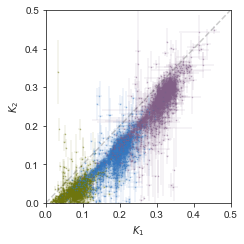

In [9]:
# make panel (a) again separately as a bitmap (otherwise the SVG is too large)
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
ax.plot([0, 1], [0, 1], "k--", alpha=0.2, label=None)
for (time, group_df), color in zip(df.groupby("time"),
                                   sns.xkcd_palette(["olive", "windows blue", "dusty purple"])):
    ax.errorbar(group_df.k1_mean, group_df.k2_mean, 
                xerr=group_df.k1_std, yerr=group_df.k2_std, 
                linewidth=0, elinewidth=0.3, marker='.', markersize=1, alpha=0.5, color=color, label=f"t = {time} min")
    #ax.scatter(group_df.k1_mean, group_df.k2_mean, linewidth=0, marker='.', color=color, label=f"t = {time} min")
ax.set_xlabel("$K_1$")
ax.set_ylabel("$K_2$")
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)
fig.tight_layout()
fig.savefig(RES_DIR / "lysine_psi_fit.png", dpi=300)

In [10]:
# calculate the value of e^(-mu*t) at the measured time points,
# by using the relative biomass compared to time 0
biomass_df = pd.read_csv(os.path.join(DATA_DIR, "2020-01-30_mlp1_triplicate_biomass_index.csv"))
labeling_df = pd.read_csv(os.path.join(DATA_DIR, "2020-01-30_Mlp1_triplicate_timers_NUPs_K1_labeling.tsv"), delimiter="\t")

# normalize each replicate by the OD at time 0
#biomass_df.loc[biomass_df.time == 0, :].set_index("replicate")
biomass_df = biomass_df.join(biomass_df.loc[biomass_df.time == 0, :].set_index("replicate"), on="replicate", rsuffix="_initial")
biomass_df["OD"] /= biomass_df.OD_initial
biomass_df.drop(["time_initial", "OD_initial"], axis=1, inplace=True)
biomass_df

res = scipy.stats.linregress(x=biomass_df.time, y=np.log(biomass_df.OD))
GROWTH_RATE = res.slope

timer_df = labeling_df[labeling_df.prey.isin(["MEX67", "KAP95", "KAP123"])].groupby(["time", "replicate"]).median()
k1_to_t = inversefunc(lambda t: lambda_k1(np.exp(-GROWTH_RATE*t), LYSINE_PSI), domain=[0, 150])
timer_df["estimated_time"] = timer_df.k1.apply(k1_to_t)

joined_df = pd.merge(timer_df, biomass_df, on=["time", "replicate"])
joined_df = joined_df.groupby("time").agg(["mean", "std"])

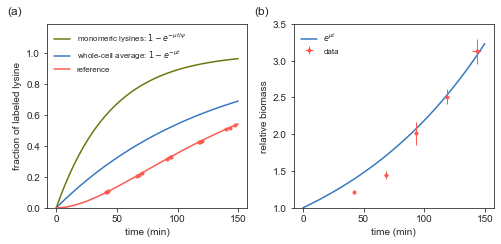

In [11]:
# Compare estimated fractions to measured biomass and measurement time
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

ax = axs[0]
ax.set_xlabel("time (min)")
ax.set_ylabel("fraction of labeled lysine")
ax.set_ylim(0, 1.19)
t_range = np.linspace(0, biomass_df.time.max(), 100)
pal = sns.xkcd_palette(["olive", "windows blue", "coral"])

ax.plot(t_range, 1-np.exp(-GROWTH_RATE*t_range/LYSINE_PSI), color=pal[0], label=r"monomeric lysines: $1-e^{-\mu t / \psi}$")
ax.plot(t_range, 1-np.exp(-GROWTH_RATE*t_range), color=pal[1], label=r"whole-cell average: $1-e^{-\mu t}$")
ax.plot(t_range, lambda_k1(np.exp(-GROWTH_RATE*t_range), LYSINE_PSI), color=pal[2], label="reference")
ax.scatter(timer_df.estimated_time, timer_df.k1, marker=".", color=pal[2], label=None, zorder=3)
ax.legend(frameon=False, fontsize=8)
ax.text(-0.2, 1.05, '(a)', fontsize=12, transform=ax.transAxes)

ax = axs[1]
ax.set_xlabel("time (min)")
ax.set_ylabel("relative biomass")

# Estimate the biomass index based on K1 of MEX67, KAP95, and KAP123 (and the inverse function with psi = 0.35)
ax.plot(t_range, np.exp(GROWTH_RATE*t_range), color=pal[1], label="$e^{\mu t}$", zorder=1)
ax.errorbar(x=joined_df[("estimated_time", "mean")], y=joined_df[("OD", "mean")],
           xerr=joined_df[("estimated_time", "std")], yerr=joined_df[("OD", "std")],
           marker=".", linewidth=0, elinewidth=1, color=pal[2], label=r"data", zorder=2)

ax.legend(loc="best", frameon=False, fontsize=8)
ax.text(-0.2, 1.05, '(b)', fontsize=12, transform=ax.transAxes)
ax.set_ylim(1, 3.5)

fig.tight_layout()
fig.savefig(RES_DIR / "od_vs_labeling.svg");

# Step 2: Using Ψ to estimate new protein fractions, and fitting a KSM model to all NUPs

In [12]:
LYSINE_PSI = 0.35

# internal reference proteins behave as 2-step systems with a phi = LYSINE_PSI,
# so we can use the same function for them
f_timers = lambda t: f_target(t, np.array([LYSINE_PSI, 1]), index=1)
f_timers_inverse = inversefunc(f_timers, domain=[0, MAX_TIME], open_domain=False)

In [13]:
def fit_phis(xdata: np.ndarray, ydata: np.ndarray, inaccessible=True):

    def f_without_inaccessible(tdata: np.ndarray, phi1: float):
        return f_target(tdata, np.array([LYSINE_PSI, phi1, 1]), index=2)
    
    def f_with_inaccessible(tdata: np.ndarray, phi1_phi2: float, z: float = 1.0):
        """
            when z = 0, both phi1 and phi2 are equal (phi1 = phi2 = sqrt(phi1_phi2))
            when z = 1, phi2 will be equal to 1 (phi1 = phi1_phi2)
        """
        phi1 = np.sqrt(phi1_phi2 * (1 - z + z*phi1_phi2))
        phi2 = np.sqrt(phi1_phi2 / (1 - z + z*phi1_phi2))
        return f_target(tdata, np.array([LYSINE_PSI, phi1, phi2]), index=2)

    if inaccessible:
        popt, pcov = curve_fit(f_with_inaccessible, xdata=xdata, ydata=ydata, p0=(0.5, 0.5), bounds=[(MIN_PHI, 0), (1, 1)])
        mse = np.mean( (ydata - f_with_inaccessible(xdata, *popt))**2 )
        phi1 = np.sqrt(popt[0] * (1 - popt[1] + popt[1]*popt[0]))
        phi2 = np.sqrt(popt[0] / (1 - popt[1] + popt[1]*popt[0]))
        phi1_phi2_std = np.sqrt(pcov[0, 0])
        phi1_std = phi1_phi2_std / phi2
        phi2_std = 0.0
    else:
        popt, pcov = curve_fit(f_without_inaccessible, xdata=xdata, ydata=ydata, p0=(0.5), bounds=[MIN_PHI, 1])
        mse = np.mean( (ydata - f_without_inaccessible(xdata, *popt))**2 )
        phi1 = popt[0]
        phi1_std = np.sqrt(pcov[0, 0])
        phi2 = 1.0
        phi2_std = 0.0

    phi = unumpy.uarray([phi1, phi2], [phi1_std, phi2_std])
    return phi, mse

def calculate_phis(data_df: pd.DataFrame) -> Tuple[pd.DataFrame, plt.Figure]:
    n_baits = len(data_df.bait.unique())
    n_preys = len(data_df.prey.unique())
    phi_data = []
    
    with tqdm(total=n_preys*n_baits) as pbar:
        for bait, bgroup_df in data_df.groupby("bait"):
            pbar.set_description(f"Processing bait {bait}")
            for prey, pgroup_df in bgroup_df.groupby("prey"):
                if pgroup_df.k1.mean() > pgroup_df.timer_k1.mean():
                    # fit with an inaccessible pool, i.e. ln(phi2) lower bound is MIN_PHI
                    phi, mse = fit_phis(pgroup_df.t.values, pgroup_df.k1.values, inaccessible=True)
                    phi_data.append((bait, prey, phi[0], phi[1], mse))
                else:
                    # fit without an inaccessible pool, i.e. ln(phi2) lower bound is 1
                    phi, mse = fit_phis(pgroup_df.t.values, pgroup_df.k1.values, inaccessible=False)
                
                    phi_data.append((bait, prey, phi[0], ufloat(1, 0), mse))
                pbar.update(1)

    return pd.DataFrame(data=phi_data,
                        columns=["bait", "prey", "phi1", "phi2", "mse"])

def plot_ksm_fits(data_df: pd.DataFrame, ksm_df: pd.DataFrame, bait: str, prey: str, ax: plt.Axes):
    t_range = np.linspace(0, MAX_TIME, 25)

    group_data_df = data_df.loc[(data_df.bait == bait) & (data_df.prey == prey), :]
    phi1, phi2, mse = ksm_df.set_index(["bait", "prey"]).loc[(bait, prey), :]
    phi_nom = np.array([LYSINE_PSI, phi1.nominal_value, phi2.nominal_value])

    ax.plot(t_range, 1.0 - np.exp(-t_range*GROWTH_RATE), color=sns.xkcd_rgb["windows blue"],
            label=r"$1 - e^{-\mu t}$", linewidth=1, zorder=1)
    ax.plot(t_range, f_timers(t_range), linewidth=1, 
            color=sns.xkcd_rgb["coral"], label="reference", zorder=1)
    for row in group_data_df.itertuples():
        ax.plot([row.t, row.t], [row.k1, row.timer_k1], linewidth=0.5, color=sns.xkcd_rgb["coral"], label=None, zorder=1)

    ax.scatter(x=group_data_df.t,
               y=group_data_df.k1,
               color=sns.xkcd_rgb["amethyst"],
               label=f"prey: {prey}", zorder=2)

    ax.plot(t_range, f_target(t_range, phi_nom, index=2), color=sns.xkcd_rgb["amethyst"], linewidth=2,
            label=f"$\phi_1$ = {phi1:.1g}, $\phi_2$ = {phi2.nominal_value:.1g}", zorder=2)

    ax.set_xlabel("time (min)")
    ax.set_ylabel("$K_1$ labeling")
    ax.legend(fontsize=7, frameon=False)

def plot_all_ksm_fits(figure_fname: str, data_df: pd.DataFrame, ksm_df: pd.DataFrame, n_cols: int=4):
    baits = sorted(data_df.bait.unique())
    preys = sorted(data_df.prey.unique())
    n_rows = int(np.ceil(len(preys)/n_cols))

    with tqdm(total=ksm_df.shape[0]) as pbar:
        with PdfPages(figure_fname) as pdf:
            for bait in baits:
                fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3.5), sharex="all", sharey="all")
                for ax, prey in zip(axs.flat, preys):
                    pbar.set_description(f"Plotting KSM fits for {bait}-{prey}")
                    plot_ksm_fits(data_df, ksm_df, bait, prey, ax=ax)
                    pbar.update(1)
                fig.suptitle(f"bait: {bait}")
                pdf.savefig(fig)
                plt.close(fig)

In [14]:
# use the original labeling data (without intermixing correction) in order to get the 
# internal standard proteins labeing (AKA NTR-timers). They do not appear in the
# corrected data file.

def calculate_sample_times():
    _df = pd.read_csv(os.path.join(DATA_DIR, "2020-02-01_10Handles_ZZ_K1_NUP_NTR_NTR-like_labeling.tsv"), delimiter="\t")
    timer_df = _df[_df.prey.isin(["KAP95", "MEX67", "KAP123"])].groupby(["bait", "time", "replicate"]).mean()[["k1"]]
    timer_df.rename(columns={"k1": "timer_k1"}, inplace=True)
    timer_df["t"] = timer_df.timer_k1.apply(f_timers_inverse)
    return timer_df

In [15]:
def calculate_labeling_data():
    timer_df = calculate_sample_times()
    _df = pd.read_csv(os.path.join(DATA_DIR, "2020-06-11_10Handle_MLP1_IntermixingCorrection.tsv"), delimiter="\t")

    if USE_INTERMIXING_CORRECTION:
        _df["k1"] = _df["K1.labeling.corrected"]
    else:
        _df["k1"] = _df["K1.labeling"]

    _df = _df.join(timer_df, on=["bait", "time", "replicate"], rsuffix="_timer")
    return _df[_df.kind == "NUP"]

In [16]:
ten_handles_data_df = calculate_labeling_data()
ten_handles_ksm_df = calculate_phis(ten_handles_data_df)

Processing bait NUP85: 100%|████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:24<00:00, 12.95it/s]


In [17]:
figure_fname = os.path.join(NEW_RES_DIR, "ten_handles_ksm_fits.pdf")
plot_all_ksm_fits(figure_fname, ten_handles_data_df, ten_handles_ksm_df, n_cols=4)

Plotting KSM fits for NUP85-SEH1: 100%|█████████████████████████████████████████████████████████████████████████| 320/320 [00:46<00:00,  6.93it/s]


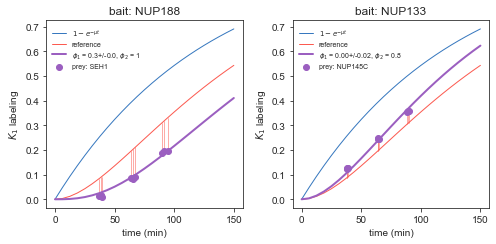

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

ax = axs[0]
bait = "NUP188"
prey = "SEH1"
plot_ksm_fits(ten_handles_data_df, ten_handles_ksm_df, bait=bait, prey=prey, ax=ax)
ax.set_title(f"bait: {bait}")

ax = axs[1]
bait = "NUP133"
prey = "NUP145C"
plot_ksm_fits(ten_handles_data_df, ten_handles_ksm_df, bait=bait, prey=prey, ax=ax)
ax.set_title(f"bait: {bait}")

fig.tight_layout()
fig.savefig(NEW_RES_DIR / "ksm_fit_example.svg")

In [19]:
res_df = ten_handles_ksm_df.copy()

DOUBLING_TIME = np.log(2) / GROWTH_RATE
maturation_time = DOUBLING_TIME * res_df.phi1 / (1.0 - res_df.phi1)
maturation_rate = GROWTH_RATE * (1.0/res_df.phi1 - 1.0)

res_df["Precursor state fraction"] = res_df.phi1.apply(nominal_value)
res_df["Precursor state fraction uncertainty"] = res_df.phi1.apply(std_dev)
res_df["Accessible fraction of mature states"] = res_df.phi2.apply(nominal_value)
res_df["Maturation time [min]"] = maturation_time.apply(nominal_value)
res_df["Maturation time [min] uncertainty"] = maturation_time.apply(std_dev)
res_df["Maturation rate [1/min]"] = maturation_rate.apply(nominal_value)
res_df["Maturation rate [1/min] uncertainty"] = maturation_rate.apply(std_dev)

res_df.drop(["phi1", "phi2", "mse"], axis=1, inplace=True)
res_df.round(4).to_csv(NEW_RES_DIR / "ten_handles_ksm_fits.csv", index=None)

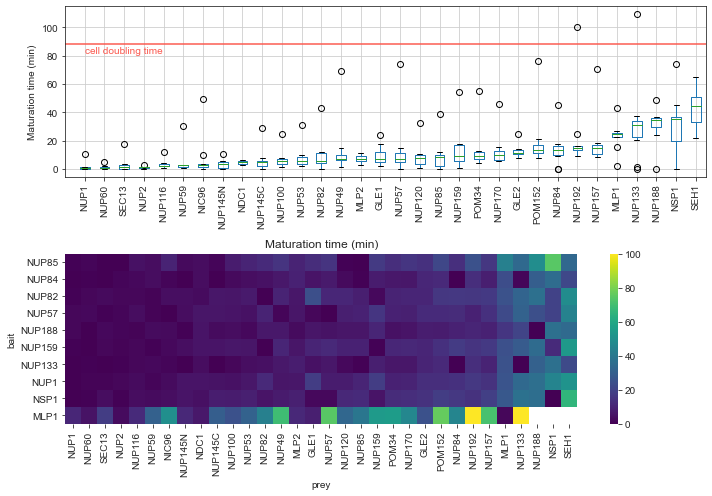

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
df = res_df.copy()
df.loc[df["Maturation time [min] uncertainty"] > 10, "Maturation time [min]"] = np.nan

pivot_df = df.pivot("bait", "prey", "Maturation time [min]")
prey_order = pivot_df.median(axis=0).sort_values().index
pivot_df = pivot_df[prey_order]

ax = axs[0]
pivot_df.boxplot(ax=ax, rot=90)
ax.plot([0, 32.5], [np.log(2) / GROWTH_RATE, np.log(2) / GROWTH_RATE], color=sns.xkcd_rgb["coral"])
ax.text(1, -2+np.log(2) / GROWTH_RATE, "cell doubling time", ha="left", va="top",
        color=sns.xkcd_rgb["coral"])
ax.set_xlim(0, 32.5)
ax.set_ylabel("Maturation time (min)")

ax = axs[1]
sns.heatmap(pivot_df.applymap(nominal_value), ax=ax, cmap="viridis", vmin=0, vmax=100)
ax.set_ylim(0, pivot_df.shape[0])
ax.set_title("Maturation time (min)")
fig.tight_layout()

fig.savefig(NEW_RES_DIR / "maturation_time.svg");

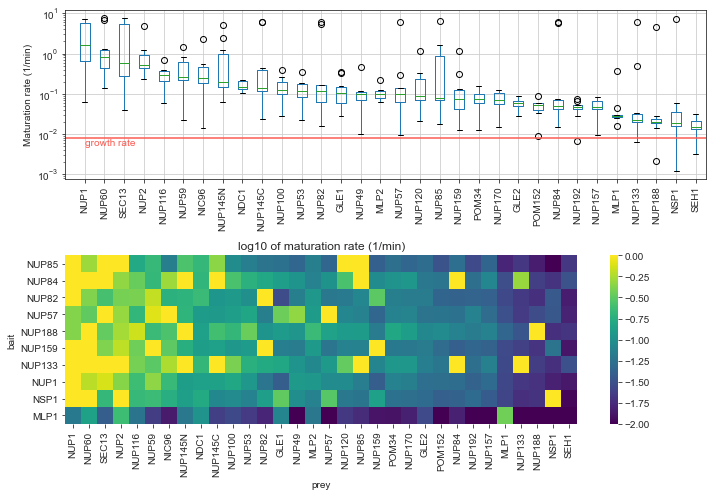

In [21]:
rc('text', usetex=False)

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
df = res_df.copy()

pivot_df = df.pivot("bait", "prey", "Maturation rate [1/min]")
prey_order = pivot_df.median(axis=0).sort_values(ascending=False).index
pivot_df = pivot_df[prey_order]

ax = axs[0]
pivot_df.boxplot(ax=ax, rot=90)
ax.plot([0, 32.5], [GROWTH_RATE, GROWTH_RATE], color=sns.xkcd_rgb["coral"])
ax.text(1, GROWTH_RATE, "growth rate", ha="left", va="top",
        color=sns.xkcd_rgb["coral"])
ax.set_xlim(0, 32.5)
ax.set_ylabel("Maturation rate (1/min)")
ax.set_yscale("log")

ax = axs[1]
sns.heatmap(np.log10(pivot_df.applymap(nominal_value)), ax=ax, cmap="viridis", vmin=-2, vmax=0)
ax.set_ylim(0, pivot_df.shape[0])
ax.set_title("log10 of maturation rate (1/min)")
fig.tight_layout()

fig.savefig(NEW_RES_DIR / "maturation_turnover.svg");

# Step 3: Running KSM fits for clustered data

In [22]:
def calculate_clustered_labeling_data():
    timer_df = calculate_sample_times()
    _df = pd.read_csv(os.path.join(DATA_DIR, "2020-06-11_10Handle_MLP1_IntermixingCorrection.tsv"), delimiter="\t")

    if USE_INTERMIXING_CORRECTION:
        _df["k1"] = _df["K1.labeling.corrected"]
    else:
        _df["k1"] = _df["K1.labeling"]

    _df = _df[_df.kind == "NUP"]

    # drop the following baits: NSP1, GLE1, NDC1
    _df = _df[~_df.bait.isin(["NSP1", "GLE1", "NDC1"])]

    clusters = {
        "MLP1": ["MLP1"],
        "*MLP2": ["MLP2"],
        "NUP1": ["NUP1"],
        "NUP57": ["NUP49", "NUP57"],
        "*NUP53": ["NUP53", "NUP170", "POM152", "POM34"],
        "NUP82": ["NUP82", "NUP159"],
        "NUP84": ["NUP84", "NUP133", "NUP145C"],
        "NUP85": ["NUP85", "NUP120"],
        "NUP188": ["NUP188"],
    }

    _df["cluster"] = ""
    for k, v in clusters.items():
        _df.loc[_df.prey.isin(v), "cluster"] = k

    # drop data of preys that are in none of the clusters
    _df = _df[_df.cluster != ""]
    _df.drop("prey", axis=1, inplace=True)
    _df.rename(columns={"cluster": "prey"}, inplace=True)

    # calculate mean and stdev for each cluster-bait pair (and also across the 3
    # replicates at the same time)
    clustered_data_df = _df.groupby(["bait", "prey", "time", "replicate"]).agg(["mean", "std"])[["k1"]]
    clustered_data_df.columns = ["k1", "k1_std"]
    clustered_data_df = clustered_data_df.reset_index().join(timer_df, on=["bait", "time", "replicate"])
    return clustered_data_df

clustered_data_df = calculate_clustered_labeling_data()
clustered_data_df

bait   prey  time  replicate        k1    k1_std  timer_k1          t
0     MLP1  *MLP2    30          1  0.046880       NaN  0.091297  39.016064
1     MLP1  *MLP2    30          2  0.047306       NaN  0.087874  38.119032
2     MLP1  *MLP2    30          3  0.046387       NaN  0.089651  38.585858
3     MLP1  *MLP2    60          1  0.140193       NaN  0.202286  65.373333
4     MLP1  *MLP2    60          2  0.141241       NaN  0.203971  65.754086
..     ...    ...   ...        ...       ...       ...       ...        ...
724  NUP85  NUP85    60          2  0.215972  0.029552  0.202418  65.403194
725  NUP85  NUP85    60          3  0.217043  0.029357  0.201753  65.252815
726  NUP85  NUP85    90          1  0.331849  0.025614  0.313489  90.563621
727  NUP85  NUP85    90          2  0.335366  0.024708  0.319711  92.001554
728  NUP85  NUP85    90          3  0.334161  0.023694  0.318393  91.696438

[729 rows x 8 columns]

In [23]:
# Run the KSM fitting and plot the results
clustered_ksm_df = calculate_phis(clustered_data_df)
figure_fname = NEW_RES_DIR / "clusters_ksm_fits.pdf"
plot_all_ksm_fits(figure_fname, clustered_data_df, clustered_ksm_df, n_cols=3)

Plotting KSM fits for NUP85-NUP85: 100%|██████████████████████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.03it/s]


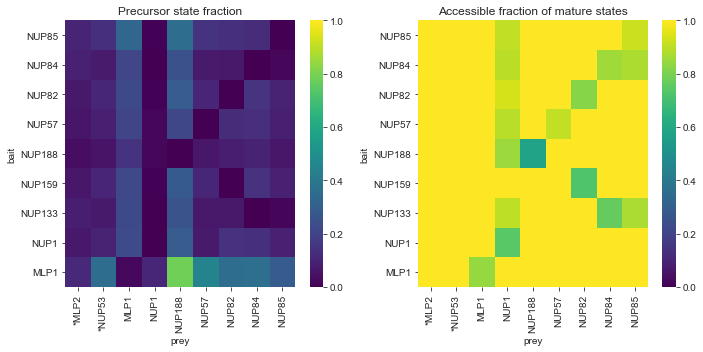

In [24]:
_df = clustered_ksm_df.copy()

DOUBLING_TIME = np.log(2) / GROWTH_RATE
maturation_time = DOUBLING_TIME * _df.phi1 / (1.0 - _df.phi1)
maturation_rate = GROWTH_RATE * (1.0/_df.phi1 - 1.0)

_df["Precursor state fraction"] = _df.phi1.apply(nominal_value)
_df["Precursor state fraction uncertainty"] = _df.phi1.apply(std_dev)
_df["Accessible fraction of mature states"] = _df.phi2.apply(nominal_value)
_df["Maturation time [min]"] = maturation_time.apply(nominal_value)
_df["Maturation time [min] uncertainty"] = maturation_time.apply(std_dev)
_df["Maturation rate [1/min]"] = maturation_rate.apply(nominal_value)
_df["Maturation rate [1/min] uncertainty"] = maturation_rate.apply(std_dev)

_df.drop(["phi1", "phi2", "mse"], axis=1, inplace=True)
_df.round(4).to_csv(NEW_RES_DIR / "clusters_ksm_fits.csv", index=None)

# plot a heatmap of all fits
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
vmin = 0
for ax, col in zip(axs.flat, ["Precursor state fraction", "Accessible fraction of mature states"]):
    pivot_df = _df.pivot("bait", "prey", col)
    sns.heatmap(pivot_df, ax=ax, cmap="viridis", vmin=0, vmax=1)
    ax.set_ylim(0, pivot_df.shape[0])
    ax.set_title(col)

fig.tight_layout()
fig.savefig(NEW_RES_DIR / "clusters_ksm_heatmap.svg")

# Step 4: Iterate all binary trees and optimize poolsizes to match the KSM Φ matrix

On a multicore server, run the following script:

`python -m script.1_fit_poolsizes -j <num_cpus> res/intermixing/clusters_ksm_fits.csv`

or

`python -m script.1_fit_poolsizes -j <num_cpus> res/without_intermixing/clusters_ksm_fits.csv`

(depending on the choice of dataset)

This will generate a result file called `res/all_trees_<DATE>_<TIME>.json.gz`

Then run:
`python -m script.2_prune_trees all_trees_<DATE>_<TIME>`

This will generate a result file called `res/all_trees_<DATE>_<TIME>_top_<N_TOP_TREES>.json`

Copy the result to the `res` folder in your local computer (where you are running this notebook)
and change the `RESULT_FNAME` accordingly.

In [48]:
# loading results from parallel run
if USE_INTERMIXING_CORRECTION:
    TREE_JSON_FNAME = NEW_RES_DIR / "all_trees_2020-06-16_22:43:43_top_2027.json"  # with MLP1, using psi = 0.35, with InterMixing correction
else:
    TREE_JSON_FNAME = NEW_RES_DIR / "all_trees_2020-02-21_20:55:47_top_2027.json"  # with MLP1, using psi = 0.35

with open(TREE_JSON_FNAME, "r") as fp:
    res_json = json.load(fp)

In [49]:
phi_df, preys, baits = load_phis(NEW_RES_DIR / "clusters_ksm_fits.csv")

level_stats = []
maturation_time_stats = []
for tree_json in res_json["trees"]:
    tree = AssemblyTree.from_json(tree_json["assembly_tree"])
    tree.set_reference_phis(phi_df)
    level_stats.append(tree.get_levels())
    maturation_time_stats.append(tree.get_maturation_times())

level_df = pd.DataFrame(data=level_stats)
mtime_df = pd.DataFrame(data=maturation_time_stats)

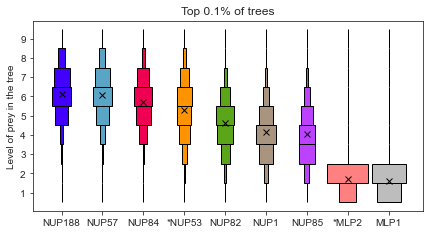

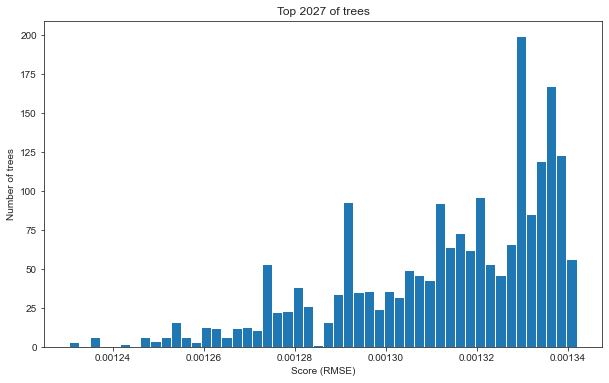

40it [00:02, 19.90it/s]                                                                                                                           


In [50]:
from matplotlib import rc
rc('font',**{'family': 'sans-serif'})
rc('text', usetex=False)

colormap = {"NUP85": "#bd42ff",
            "NUP84": "#ef0052",
            "NUP145C": "#ef0052",
            "NUP133": "#ef0052",
            "*NUP53": "#ff9400",
            "NUP82": "#5aa518",
            "NUP159": "#5aa518",
            "NUP57": "#5aa5c6",
            "NUP49": "#5aa5c6",
            "NUP188": "#4200ff",
            "MLP1": "#bdbdbd",
            "*MLP2": "#ff8080",
            "NUP1": "#a99480"
           }

# Generate a single PDF file with all 0.1% top trees (in batches of 40=8x5 per page)
with PdfPages(NEW_RES_DIR / "top_permille_graphs.pdf") as pdf:

    fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
    hist_range = (0, len(preys)+1)
    number_of_bins = len(preys)+1
    binned_data_sets = []

    prey_order = level_df.mean().sort_values(ascending=False).index.tolist()

    for prey in prey_order:
        levels = level_df[prey]
        binned_data_sets.append(np.histogram(levels, range=hist_range, bins=number_of_bins)[0])

    binned_maximums = np.max(binned_data_sets, axis=1)
    x_locations = np.arange(0, len(binned_data_sets)) * np.max(binned_maximums)

    # The bin_edges are the same for all of the histograms
    bin_edges = np.linspace(hist_range[0], hist_range[1], number_of_bins + 1)
    centers = 0.5 * (bin_edges + np.roll(bin_edges, 1))[:-1]
    heights = np.diff(bin_edges)

    for x_loc, binned_data, prey in zip(x_locations, binned_data_sets, prey_order):
        lefts = x_loc - 0.5 * binned_data
        ax.barh(0.5+centers, binned_data, height=heights, left=lefts, color=colormap[prey],
                linewidth=1, edgecolor="k")
        ax.plot(x_loc, level_df[prey].mean(), 'kx')

    ax.set_xticks(x_locations)
    ax.set_xticklabels(prey_order)
    ax.set_yticks(range(1, 10))
    ax.set_title("Top 0.1% of trees")
    ax.set_ylabel("Level of prey in the tree")
    ax.set_xlim(-1000, None)
    
    display(fig)
    fig.savefig(NEW_RES_DIR / "tree_level_histogram.pdf")
    pdf.savefig(fig)
    plt.close(fig)
    
    # Plot histogram of all top scores
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    all_scores = [tree_json["score"] for tree_json in res_json["trees"]]
    ax.hist(all_scores, bins=50)
    ax.set_title(f"Top {len(all_scores)} of trees")
    ax.set_xlabel("Score (RMSE)")
    ax.set_ylabel("Number of trees")

    display(fig)
    fig.savefig(NEW_RES_DIR / "tree_score_histogram.pdf")
    pdf.savefig(fig)
    plt.close(fig)
    
    # Plot graphs for all the top trees
    n_trees = 3#len(res_json["trees"])
    n_cols = 5
    n_rows = 8
    with tqdm(total=n_trees) as pbar:
        for i in np.arange(0, n_trees, n_cols*n_rows):
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*6))

            for ax, tree_json in zip(axs.flat, res_json["trees"][i:]):
                tree = AssemblyTree.from_json(tree_json["assembly_tree"])
                tree.plot_tree(ax=ax)
                ax.set_title(f"score = {tree_json['score']:.6f}")
                pbar.update(1)
            pdf.savefig(fig)
            plt.close(fig)

## Generate more statistics using the top 0.1% of trees

In [51]:
tiers = [
    ["NUP57", "NUP84", "*NUP53", "NUP188"],
    ["NUP1", "NUP85", "NUP82"],
    ["MLP1", "*MLP2"],
]

df = pd.read_csv(NEW_RES_DIR / "clusters_ksm_fits.csv")

tier_mat_times_data = []
for i1, tier1 in enumerate(tiers):
    for i2, tier2 in enumerate(tiers):
        if i1 == i2+1:
            _df = df[df.bait.isin(tier1) & df.prey.isin(tier2)]
            medi = _df["Maturation time [min]"].median()
            mini = _df.groupby("prey").min()["Maturation time [min]"].median()
            tier_mat_times_data.append((i1, i2, medi, mini))

# estimate the maturation time for MLP1 as the final step in the NPC biogenesis
# by taking the median value across all baits (that are not MLP1).
# since MLP1 is the last protein to join the complex, the maturation time
# should not depend on the bait.

t_mlp1 = df.loc[(df.bait != "MLP1") & (df.prey == "MLP1"), "Maturation time [min]"].median()
tier_mat_times_data.append((2, 2, t_mlp1, t_mlp1))
tier_mat_times_df = pd.DataFrame(data=tier_mat_times_data, columns=["bait tier", "prey tier", "median", "minimum"])

In [52]:
for _, row in tier_mat_times_df.iterrows():
    print(f"Estimated maturation time for step {row['prey tier']+1:.0f}: {row['minimum']:.1f} - {row['median']:.1f} minutes")

Estimated maturation time for step 1: 10.9 - 14.5 minutes
Estimated maturation time for step 2: 35.8 - 35.8 minutes
Estimated maturation time for step 3: 24.9 - 24.9 minutes


<AxesSubplot:xlabel='prey2', ylabel='prey1'>

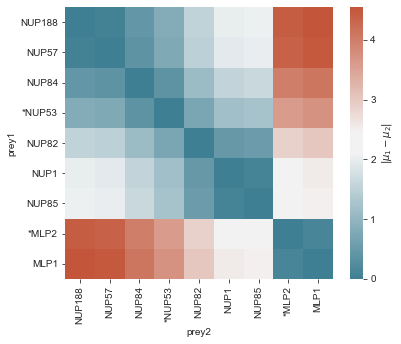

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
diff_data = []
for col1 in prey_order:
    for col2 in prey_order:
        diff_data.append((col1, col2, (level_df[col1] - level_df[col2]).mean()))
diff_df = pd.DataFrame(data=diff_data, columns=["prey1", "prey2", "mean-dist"])
diff_df = diff_df.pivot("prey1", "prey2", "mean-dist")
diff_df = diff_df.loc[prey_order, :]
diff_df = diff_df.loc[:, prey_order]

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(np.abs(diff_df), cmap=cmap, cbar_kws={"label": r"$|\mu_1 - \mu_2|$"}, ax=ax)

<AxesSubplot:>

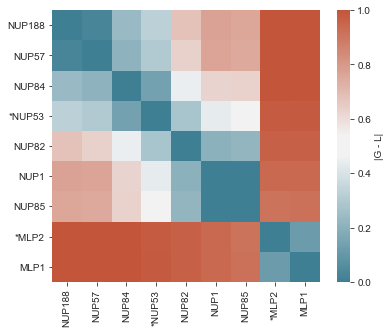

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# heatmap based on |G-L|, i.e. the fraction of times level1 > level2 minus the fraction of times level2 > level1
prey_order = level_df.mean().sort_values(ascending=False).index.tolist()
df = pd.DataFrame(columns=prey_order, index=prey_order, dtype=float)
for prey1, prey2 in itertools.product(prey_order, prey_order):
    levels1 = level_df.loc[0:, prey1]
    levels2 = level_df.loc[0:, prey2]
    df.at[prey1, prey2] = ((levels1 < levels2).sum() - (levels1 > levels2).sum()) / level_df.shape[0]

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(np.abs(df), cmap=cmap, cbar_kws={"label": "|G - L|"}, ax=ax)

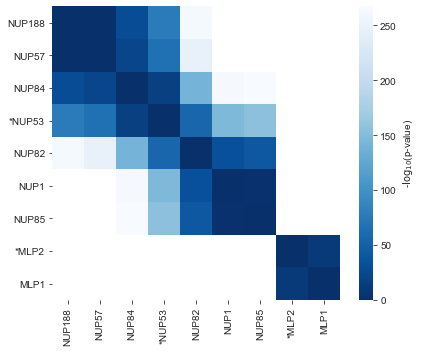

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# calculate p-value of pairwise ranksum tests for the tree-level histograms
prey_order = level_df.mean().sort_values(ascending=False).index.tolist()
df = pd.DataFrame(columns=prey_order, index=prey_order, dtype=float)
for prey1, prey2 in itertools.product(prey_order, prey_order):
    if prey1 == prey2:
        df.at[prey1, prey2] = 1
    else:
        levels1 = level_df[prey1]
        levels2 = level_df[prey2]
        pval = scipy.stats.ranksums(levels1, levels2).pvalue
        if pval < 1e-300:
            df.at[prey1, prey2] = np.nan
        else:
            df.at[prey1, prey2] = pval
sns.heatmap(-np.log10(df), cmap="Blues_r", cbar_kws={"label": r"-$\log_{10}$(p-value)"}, ax=ax)

fig.tight_layout()
fig.savefig(NEW_RES_DIR / "tree_level_pairwise.pdf")